### 遗传算法

**遗传算法**是一种优化方法，其源于达尔文的自然选择学说。自然选择学说认为，在特定的环境下，各种生物的那些适应所在环境特点的功能有更高可能在代际遗传中得到保留（举例而言，在高寒地区的动物通常长有非常厚的毛）。自然选择在以下条件下就会产生：

* 各种生物要有办法将自己的遗传特征传给后代
* 环境中的遗传特征种类多种多样
* 只有部分生物体才可以将自己的遗传特征传给后代，也就是“适者生存”

这种“仿生学”的方法如何在算法中应用呢？

#### 场景

假设我们随机抽取100个用户来公司参观，并与自己喜欢的老师和产品经理互相交流。在他们来公司前，我们送了一组问卷，问卷内容包括：

* 对数学视频的喜好程度
* 对物理视频的喜好程度
* 对英语视频的喜好程度

在问卷中，他们需要对每个问题打一个分数，10分为最喜欢，0分为最不喜欢。

现在，这100位用户会分坐10行10列，由于活动需要，我们需要保证同一个人的前、后、左、右邻座不能和这个人有很大的兴趣差异。

他们的问卷数据在`questionnaire.csv`中，现在，你需要**用pandas 读取，并输出数据的前5行**

In [1]:
import pandas as pd

# 读取 questionnaire.csv, 存到 df 中，并将第一列（uid）设置为索引
### CODE HERE
df = pd.read_csv("./questionnaire.csv",index_col='uid')
df.head()

,math,physics,english
uid,,,
1,0,4,7
2,5,2,0
3,5,1,3
4,9,1,8
5,9,1,8


有了数据，首先我们可以尝试将问题和数据形式化。在这个问题里，我们的输出显然是个10×10的矩阵，我们可以通过这个矩阵为这100个用户安排座位。为了让遗传算法听起来更有生物范儿，我们可以把矩阵叫做“染色体”，把矩阵中每个元素（座位和座位上的用户）叫做“基因”，这样我们就可以提出很多染色体，这些染色体有的符合问题的要求，有的不符合。

所以，我们可以先随机生成10个染色体。**请将所有uid随机分配到一个名为 `user_mat` 的10×10的numpy矩阵中**

In [2]:
import numpy as np
user_mat=np.random.choice(df.index,replace=False,size=100).reshape((10,10))
### CODE HERE

接下来，**随机"shuffle" `user_mat` 十次，并将返回的“染色体”保存到 `initial_population`**

In [3]:
initial_population = []
for x in range(10):
    user_mat = np.random.permutation(range(1, 101)).reshape((10,10))
    initial_population.append(user_mat)

In [4]:
initial_population

[array([[ 70,  24,  54,  97,  35,  93,  26,   7,  27,  80],
        [ 96,  90,  72,  62,  83,  69,  15,  92,  53,  39],
        [ 43,  89,  18,   4,  87,  52,  99,  12,  55,  50],
        [ 28,  46,  78,  13,  33,  88,  10,   1,  29,  63],
        [ 41,  51,   2,  74,   6,  56,  71,   8,   5,  30],
        [ 37,  94,  86,  95,  91,  66,  49,  77,  47,  19],
        [ 25,  76,  98,  61,  48,  17,  11,   9,  57,  32],
        [ 67,  38,  64,  44,  31,  84,  65,  36,  45,  81],
        [ 85, 100,  59,  14,  16,   3,  34,  42,  22,  60],
        [ 79,  58,  75,  20,  23,  40,  68,  21,  82,  73]]),
 array([[ 89,  69,  21,  38,  63,  84,  32,  73,   9,  22],
        [ 56,  90,  74,  49,  27,  45,  52,  83,  96,  30],
        [ 85,  77,   2,  54,  58,  72,  76,  36,  39,  20],
        [ 55,  93,  82,  41,  78,  94,  26,   8,  60,  92],
        [ 68,  35,  34,  23,  13,  16,  70,  48,  19,  64],
        [ 15,  67, 100,  62,  97,  42,  50,  47,  51,  46],
        [ 12,   3,  33,   6,  71,   4,

#### 适者生存

接下来是重头戏 —— 适者生存环节了。我们如何让这10条染色体“弱肉强食，适者生存”呢？

刚刚说到，我们需要保证同一个人的前、后、左、右邻座不能和这个人有很大的兴趣差异。那么首先就要衡量这种“差异”。

请**写一个函数，输入是用户A（`person`）和一组用户B的数据（`*others`），返回A同B中每个用户喜好的平均曼哈顿距离**。

In [5]:
from scipy.spatial.distance import pdist

def calculate_interest_distance(person, *others):
    people = [df.ix[person, 0:3]]
    for other in others:
        if other:
            people.append(df.ix[other, 0:3])

    return np.average(pdist(people,metric='minkowski',p=1)) if len(people) > 1 else 0

现在我们已经有了衡量“差距”的方法，我们就可以将其作为染色体“适应性”的度量。

接下来自然是为每条染色体的每个基因计算其距离了。我们会遍历每条染色体，为所有基因计算它与它前、后、左、右四个neighbor的距离。由于并非所有基因都有前后左右四个邻居，本着防御性编程的精神，我们先写个函数处理对应邻居不存在的意外情况。

In [6]:
def get_element_safe(sequence, position):
    try:
        return sequence.item(position)
    except IndexError:
        return None

接下来就可以动手了！请**补全`calculate_chromosome_fitness`函数，该函数接收一个染色体，并为该染色体上的每个基因计算曼哈顿距离，最后以这些距离的平均值作为这条染色体的“适者程度”**

In [7]:
def calculate_chromosome_fitness(chromosome):
    fitnesses = []
    for index, gene in np.ndenumerate(chromosome):
        next_to_right = calculate_interest_distance(gene,
                                             get_element_safe(chromosome, (index[0], index[1])),
                                             get_element_safe(chromosome, (index[0], index[1] + 1)))
        next_to_left = calculate_interest_distance(gene,
                                             get_element_safe(chromosome, (index[0], index[1])),
                                             get_element_safe(chromosome, (index[0], index[1] - 1)))
        in_front = calculate_interest_distance(gene,
                                             get_element_safe(chromosome, (index[0], index[1])),
                                             get_element_safe(chromosome, (index[0]+1, index[1])))
        behind = calculate_interest_distance(gene,
                                            get_element_safe(chromosome, (index[0], index[1] - 1)),
                                            get_element_safe(chromosome, (index[0]-1, index[1] + 1)))
        fitnesses.append(sum([next_to_right,next_to_left,in_front, behind]) / 4)
    return np.average(fitnesses)

好的，这样我们就可以比较刚刚产生的10条染色体了。现在可以遍历每条染色体，计算染色体适应性，最后将相关信息保存起来。

In [8]:
generations = []

for chromosome in initial_population:
    generations.append({
        "generation": 0,
        "fitness": calculate_chromosome_fitness(chromosome),
        "chromosome": chromosome,
        "active": True
    })

D:\anconda\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
D:\anconda\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


现在来看看结果吧！请**以 `fitness` 为 key，为generations排序**

In [9]:
# CODE HERE
sorted(generations,key= lambda x:x["fitness"])

[{'active': True,
  'chromosome': array([[ 78,  24,  90,  64,  47,  69,   8,  18,  32,  29],
         [ 37,  88,   5,  13,  46,  76,  17,  10,   6,  89],
         [ 68,  97,  54,  61,  41,  25,  11,  63,  57,  91],
         [ 19,  36,  83,  80,  43,  58,  22,  35,  74,  94],
         [ 44,  60,  48,  55,  12,  77,  96,  75,   2,  23],
         [ 20,  14,  86,  79,  98,  95,  62,  73,  28,  51],
         [ 85,  93,  99,  56,   3,  53,   1,  81,  39,  30],
         [ 59,  92,  21,  40,  87,  42,  71,  82,  67,  38],
         [ 34,  52,  72,  66,  31,  84,  16,   7,   9,  65],
         [ 27,  49,  50,   4, 100,  26,  15,  70,  33,  45]]),
  'fitness': 6.9075000000000015,
  'generation': 0},
 {'active': True,
  'chromosome': array([[ 66,  29,   8,  62,  87,  49,  32,  35,  64,  46],
         [ 98,  73,  55,  86,  54,  94,  31,  96,  38,   5],
         [  6,  48,  10,  59,  11,  23,  40,  19,   1,  95],
         [ 26,  76,  85,  15,  78,  42,  89,  22,  99,  56],
         [ 68,  12,  50,  1

#### 繁衍生息

接下来就要真正的“适者生存”了。在进化论中，只有优秀的基因才有资格繁衍出下一代。我们要让两个优秀染色体结合，“生出“一个孩子来。

具体的”繁衍规则“可以多种多样，在这里我们规定如下：
* 对于id在1-50的用户，其基因来自于母亲
* 对于id在51-100的用户，其基因来自于父亲
* 如果基因有冲突（两个用户被指向同一个位置），就再随机挑选一个位置

现在请**补全”遗传规则“**

In [10]:
import random

def recombine(mother, father):
    child = np.ones((10,10)) * -1
    # 遍历每个用户
    for index, uid in enumerate(df.index):
        if uid <= 50:
            # 如果uid <=50，则position为mother中该uid的位置
            position = np.where(mother == uid)
        else:
            # 如果uid > 50，则position为father中该uid的位置
            position = np.where(father == uid)
        
        if child[position] != -1:
            # 处理冲突
            filtered = np.where(np.equal(child, -1))
            position = random.choice(list(zip(filtered[0], filtered[1])))

        child[position] = uid

    return child

但是这种遗传规则可能会导致”近亲遗传“，进而不利于物种的进化，还好我们可以设计一套基因变异的方案，也就是随机调换一些基因（就是用户座位）的位置，以保证生物多样性。

In [11]:
import random

def mutate_chromosome(chromosome):
    first = (random.randrange(0, 10, 1), random.randrange(0, 10, 1))
    second = (random.randrange(0, 10, 1), random.randrange(0, 10, 1))

    chromosome[first[0], first[1]], chromosome[second[0], second[1]] = chromosome[second[0], second[1]], chromosome[first[0], first[1]]
    return chromosome

#### 可视化

接下来我们来将每条染色体的适应性都可视化出来，为了更生物一点，我们用类似于基因图谱的形式绘制每条染色体的基因情况

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_population(population, generation):
    get_ids = np.vectorize(df.index)
    figure, axes = plt.subplots(1, 10, figsize=(20, 3))

    for index, chromosome in enumerate(population):
        ids = chromosome
        axes[index].imshow(ids, interpolation="nearest", cmap=plt.cm.plasma)
        subplot_title = "Chromosome " + str(index)
        axes[index].set_title(subplot_title)

    plot_title = "Generation " + str(generation)
    figure.suptitle(plot_title)
    plt.show()

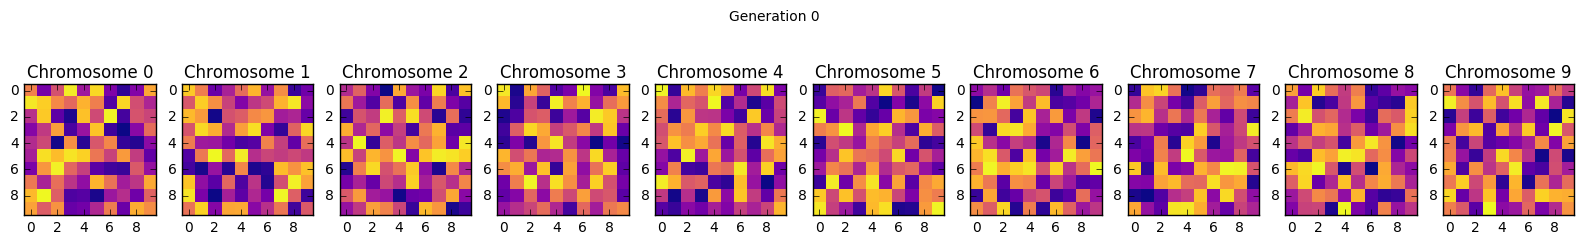

In [13]:
draw_population(initial_population, 0)

#### 又到了交配的季节

现在就可以交配了。我们可以设定如下终止条件，如果终止条件没有被触发，就可以一直交配下去：
* 代数达到上限
* 后代的适应性超过阈值
* 后代适应性退化

这里我们迭代最多50次，在50代交配中，只要有染色体达到或超过优质标准（距离小于5）就停止。

现在来实现交配逻辑吧！


In [14]:
import copy

most_fit = []

# 当前的适应度
max_fitness = None

# 适应度最高的染色体
fittest_chromosome = None

In [15]:
### 从generations取出某一代的所有染色体，并排序
def get_chromosomes_in_generation(generations, generation_num):
    # Get only the chromosomes in this generation
    generation = list(filter(lambda k: k['generation'] == generation_num, 
                             generations))
    return sorted(generation, key=lambda k: k['fitness'])


### 更新 most_fit / max_fitness / fittest_chromosome 
def sort_chromosomes(generation, most_fit):
    max_fitness = generation[0]['fitness']
    most_fit.append(max_fitness)
    fittest_chromosome = generation[0]['chromosome']
    return most_fit, fittest_chromosome

在这个交配游戏中，每一代我们都会让适应度最好的四个染色体交配，生下两个后代，然后杀掉适应度最差的两个染色体以取而代之。为了防止数据污染，对每一代我们都复制仍存活的染色体数据。

In [16]:
# 请将以下Comment 添加到代码的合适位置
# A. 将适应度最高的两条染色体交配
# B. 将新一代染色体加入到generations中并返回
# C. 将适应度最差的两个染色体杀掉
# D. 找到仍存活的染色体，并更新代数
# E. 将适应度第三和第四高的两条染色体交配


def copy_chromosomes(generation, generations):
    new_generation = copy.deepcopy(generation)
    
    new_generation[-1]['active'] = False
    new_generation[-2]['active'] = False
    
    active = list(filter(lambda k: k['active'] == True, new_generation))
    for chromosome in active:
        chromosome['generation'] += 1
    
    
    generations.extend(active)
    return generations


def mate_chromosomes(generation, generations, generation_num):
    
    child = recombine(generation[0]['chromosome'], generation[1]['chromosome'])
    child = mutate_chromosome(child)
    generations.append({
      "active": True,
      "chromosome": child,
      "generation": generation_num + 1,
      "fitness": calculate_chromosome_fitness(child)
    })

    other = recombine(generation[2]['chromosome'], generation[3]['chromosome'])
    other = mutate_chromosome(chromosome)
    generations.append({
      "active": True,
      "chromosome": other,
      "generation": generation_num + 1,
      "fitness": calculate_chromosome_fitness(other)
    })
    return generations

最后，我们用一个`main`函数将这些步骤封装起来

In [17]:
def run_ga(input_generations):
    fittest = []
    max_fitness = None
    fittest_chromo = None
    for generation_num in range(50):
        if max_fitness and max_fitness < 5:
            break

        generation = get_chromosomes_in_generation(input_generations, generation_num)
        fittest, fittest_chromo = sort_chromosomes(generation, most_fit)

        input_generations = copy_chromosomes(generation, input_generations)
        input_generations = mate_chromosomes(generation, input_generations, generation_num)

        draw_population(map(lambda d: d['chromosome'], 
                        get_chromosomes_in_generation(input_generations, generation_num)), generation_num)

    return fittest, fittest_chromo

D:\anconda\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
D:\anconda\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


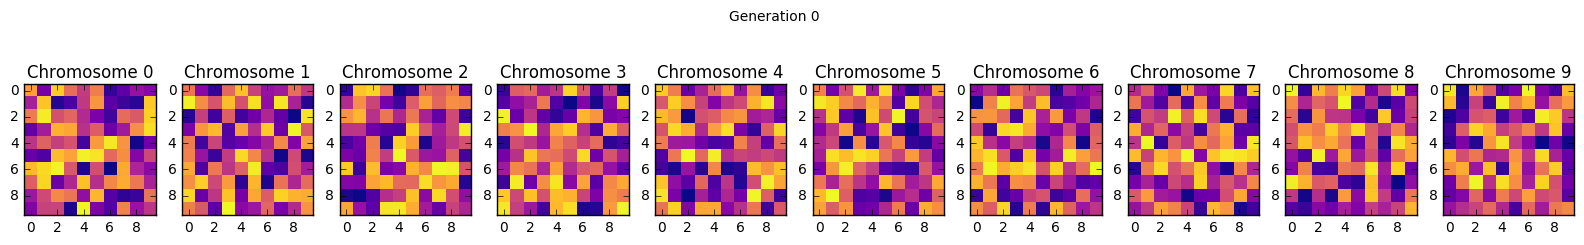

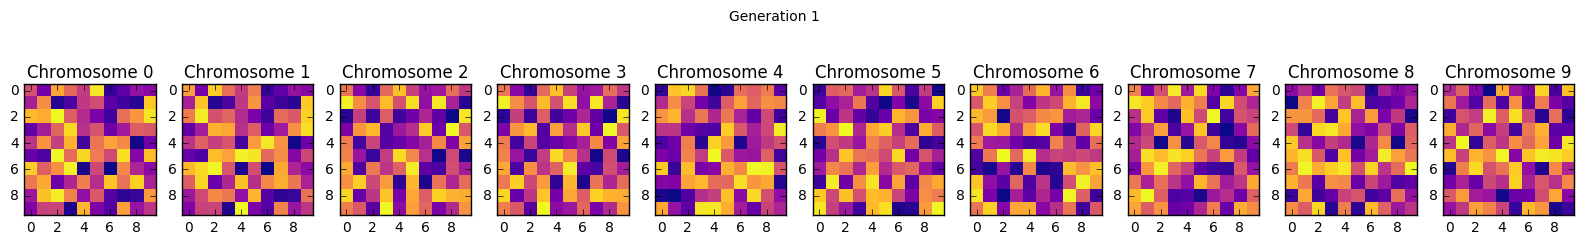

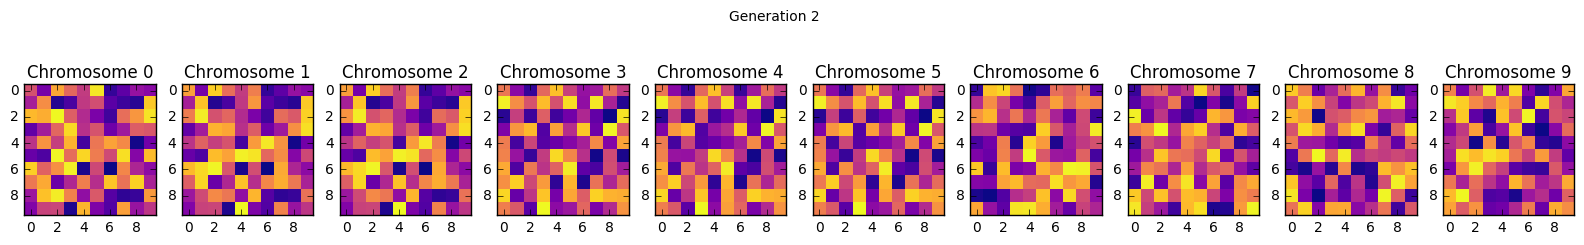

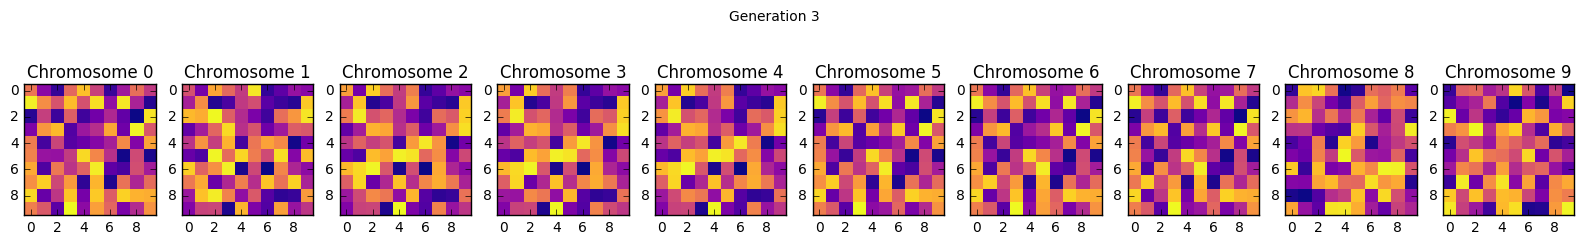

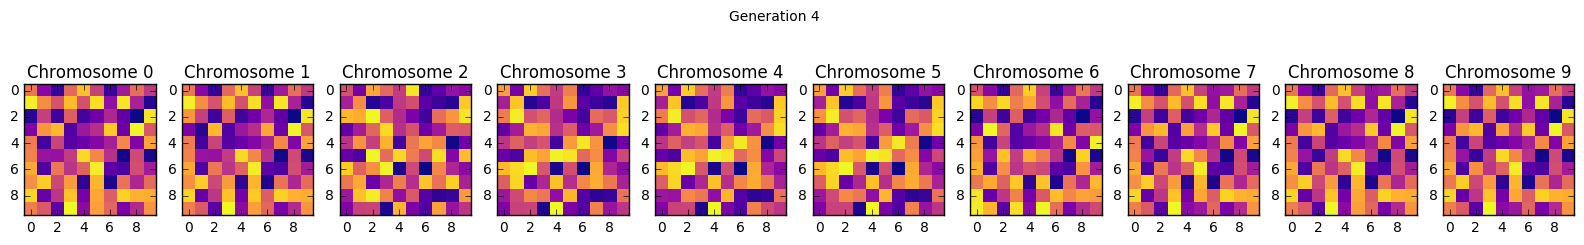

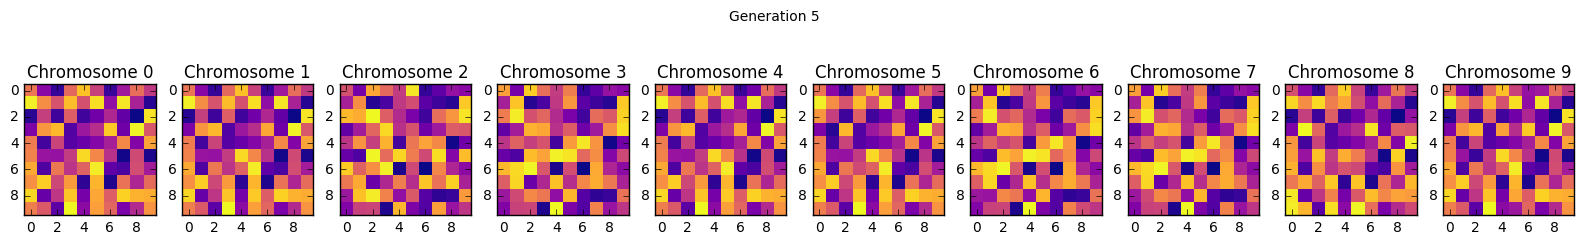

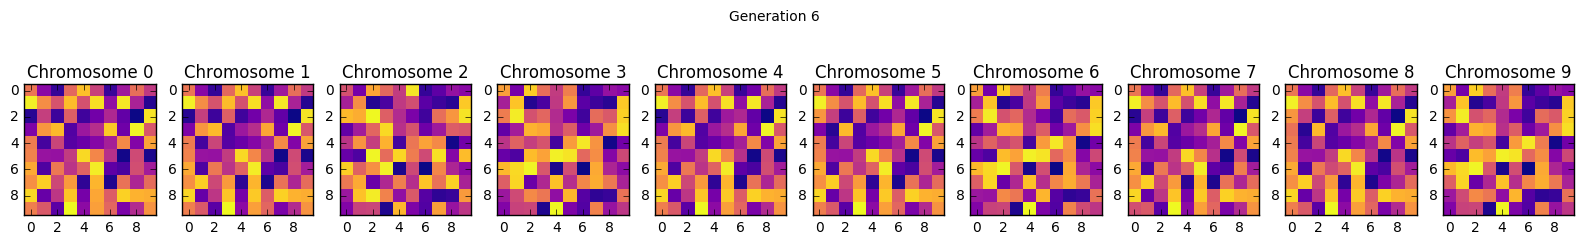

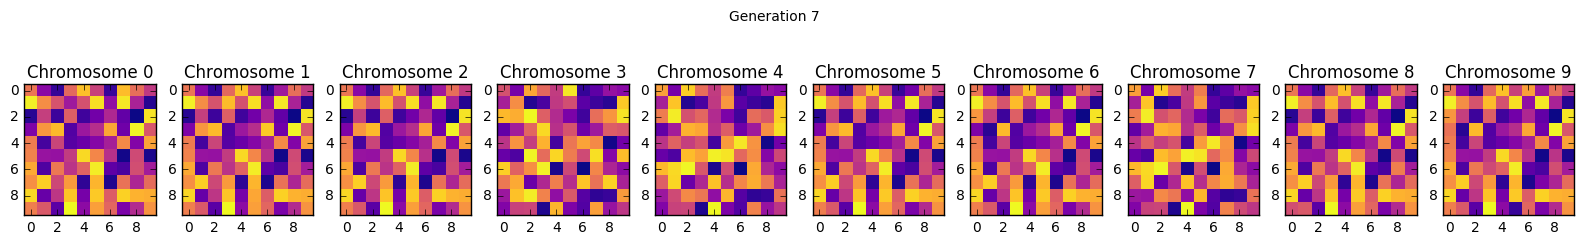

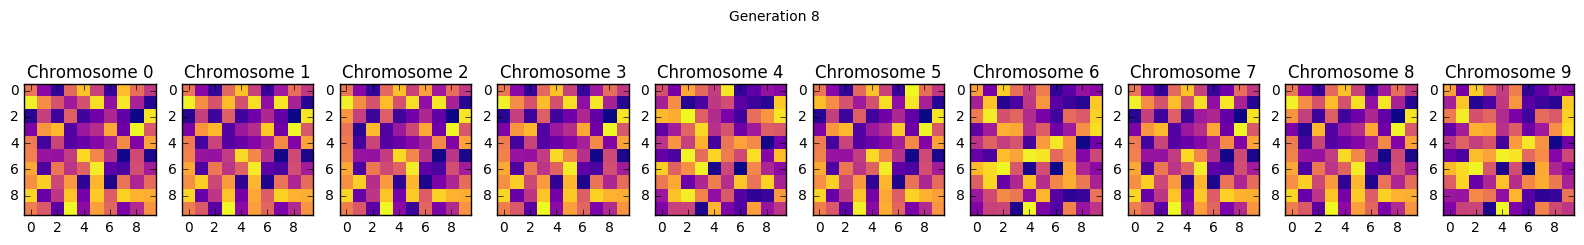

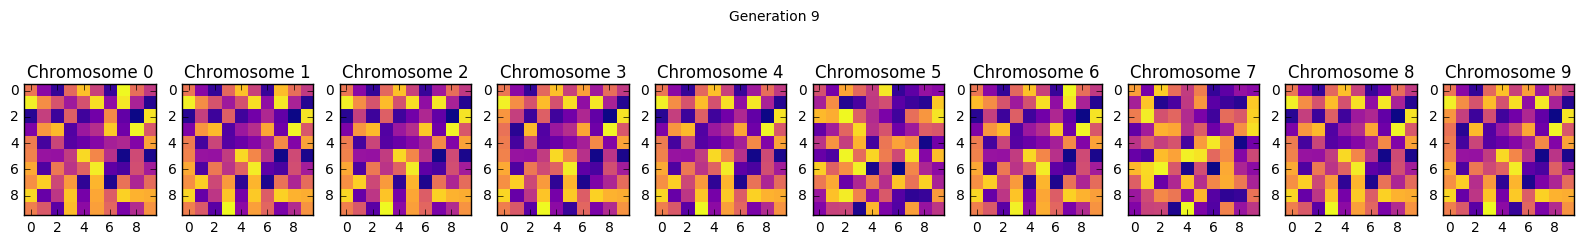

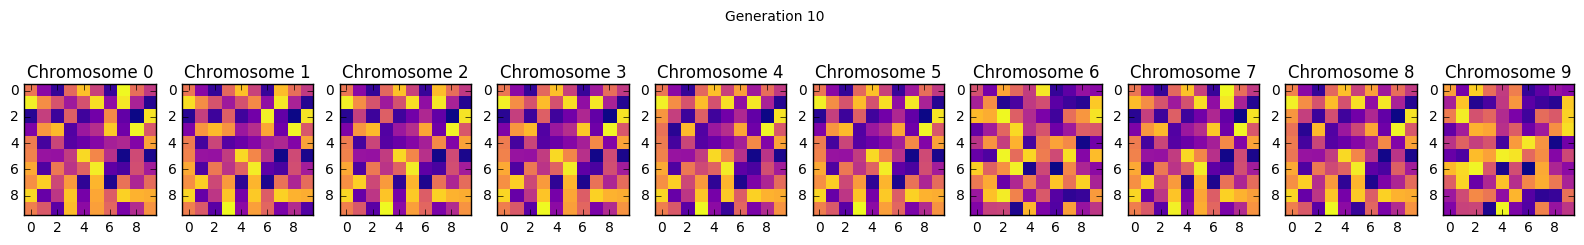

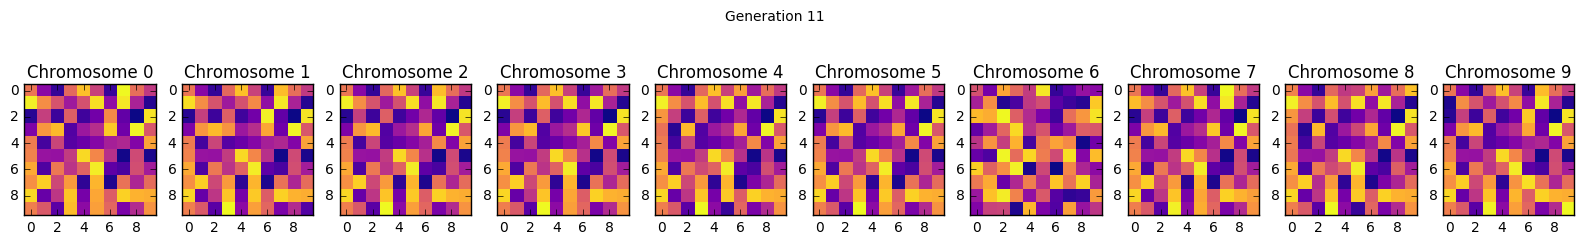

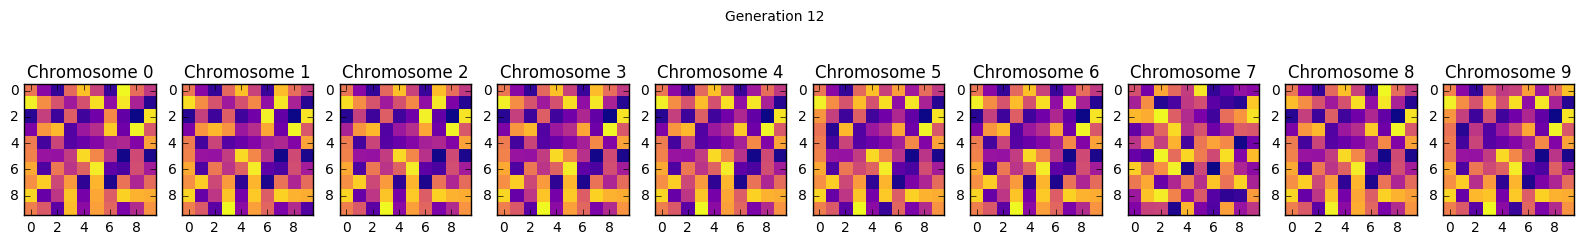

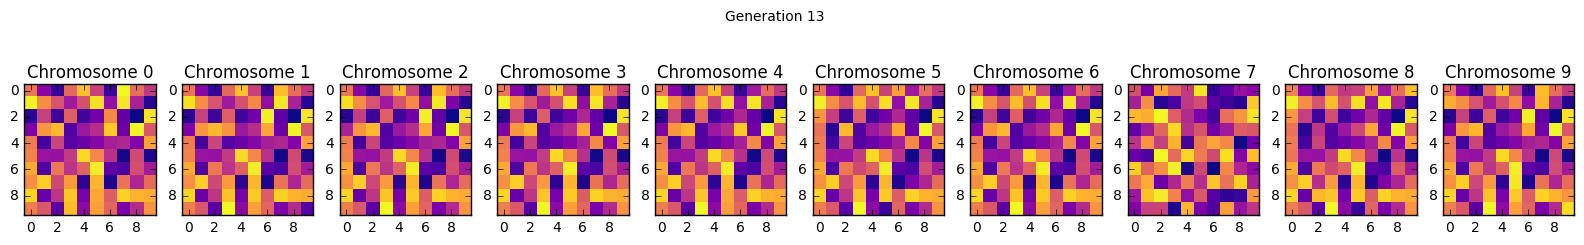

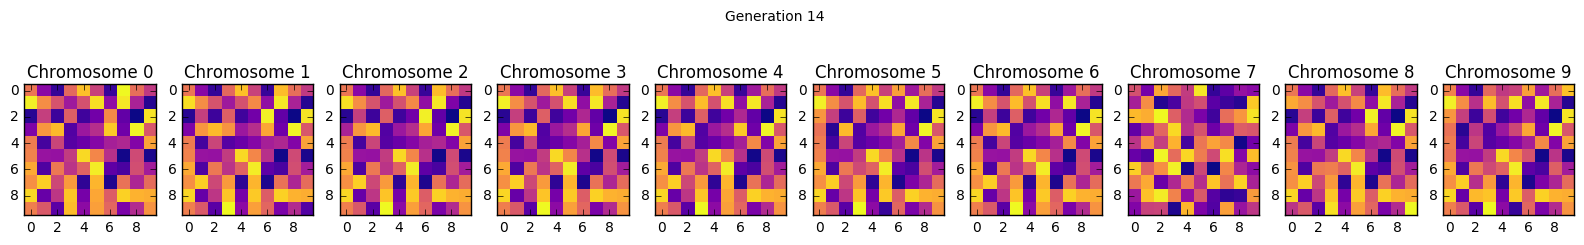

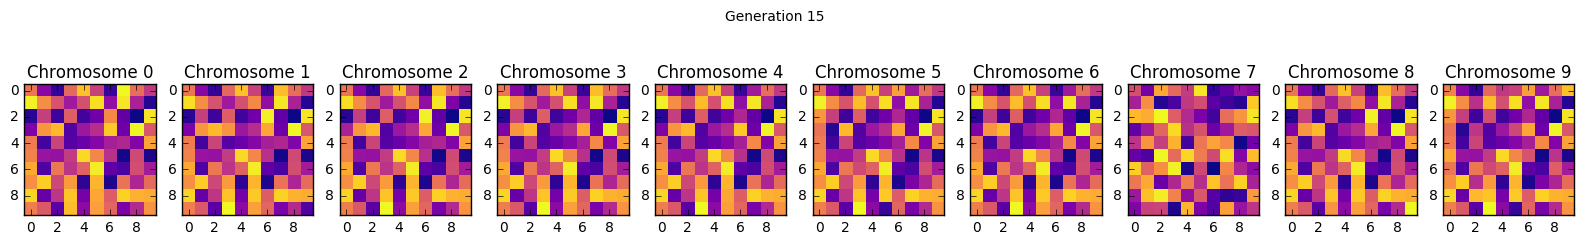

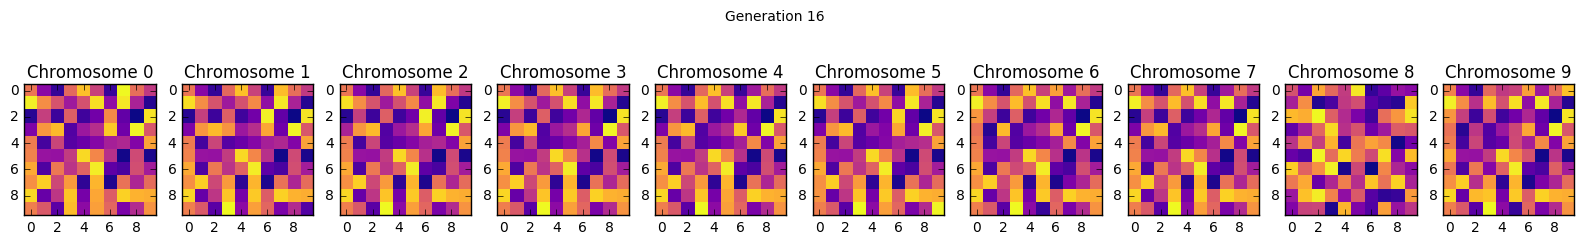

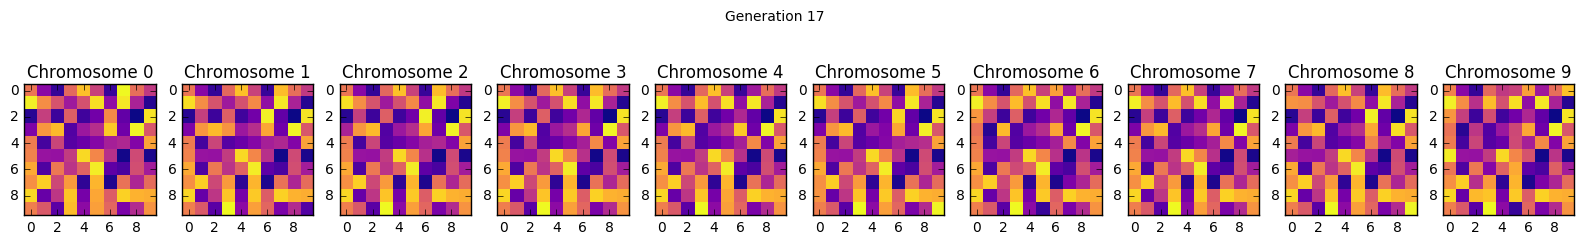

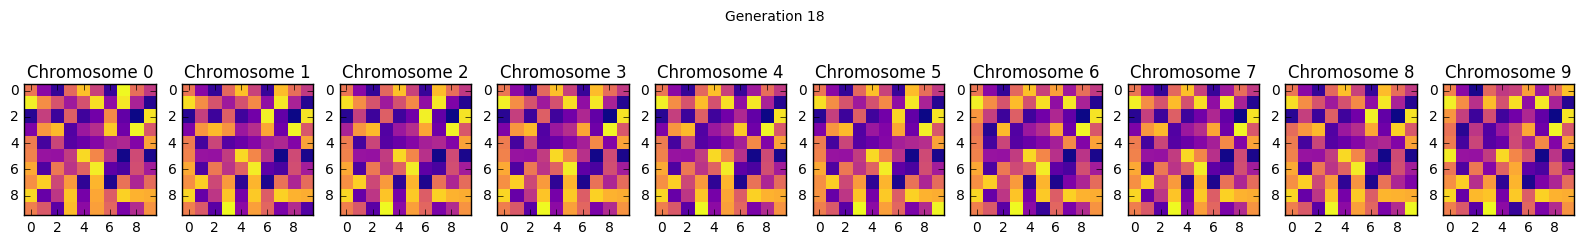

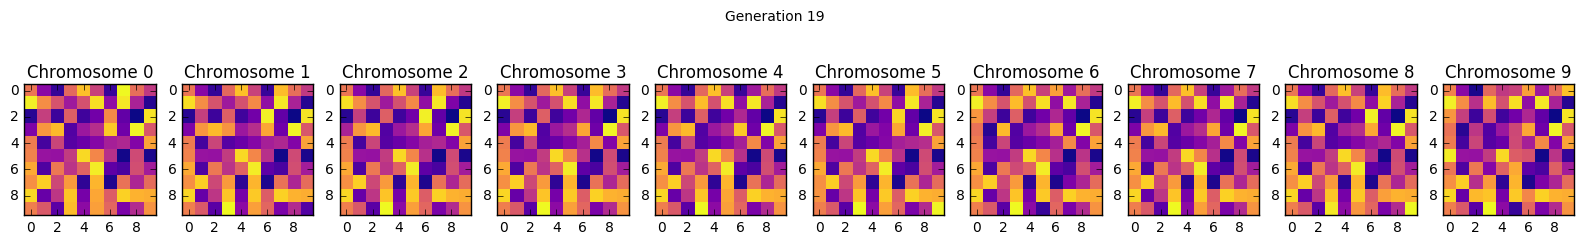

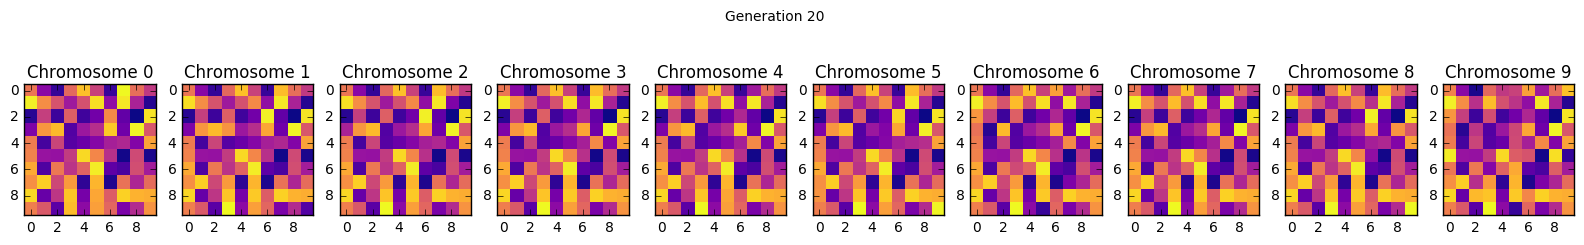

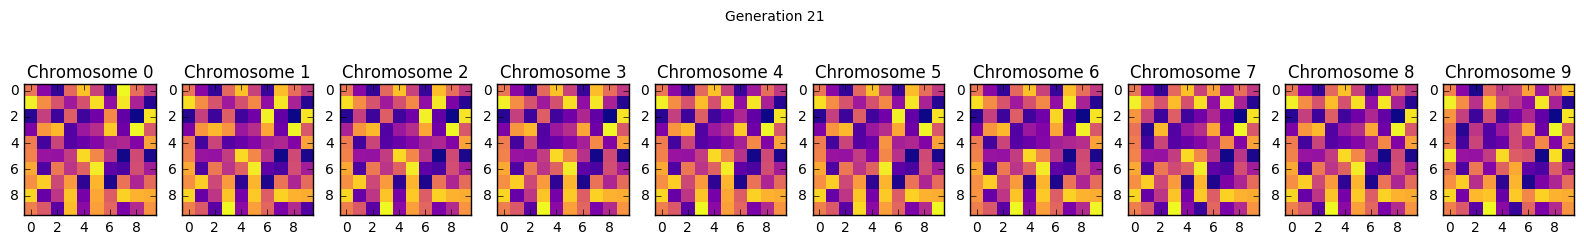

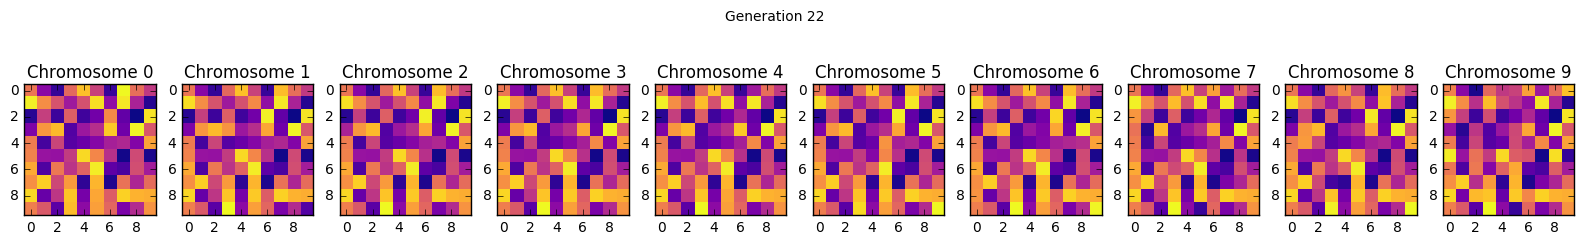

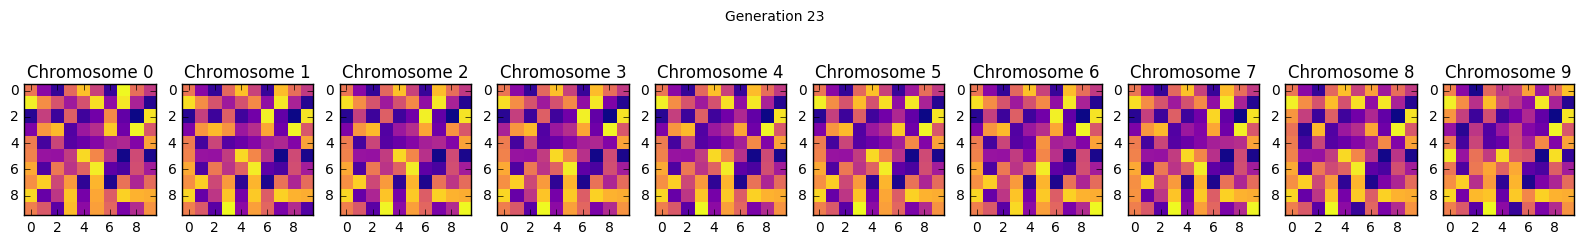

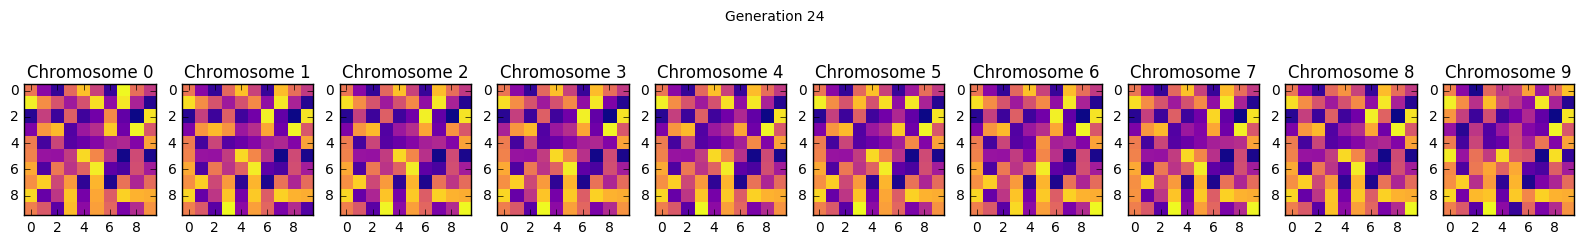

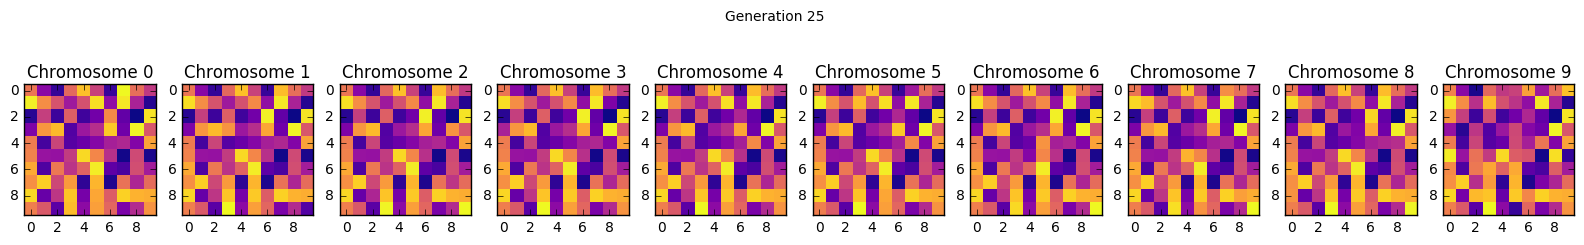

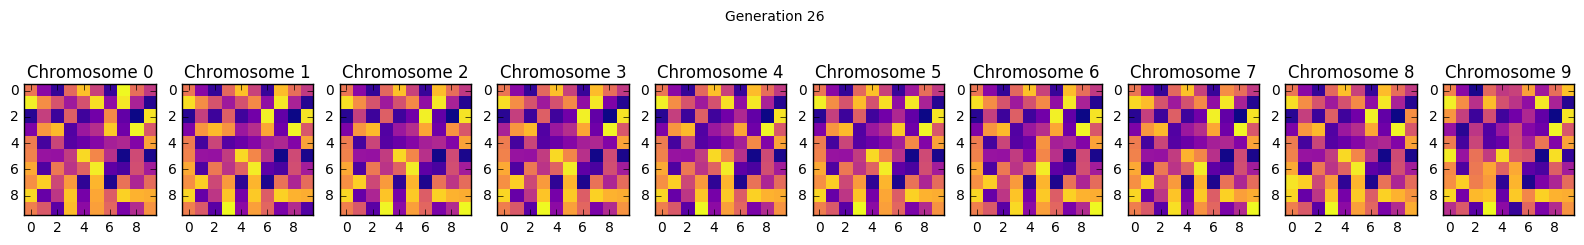

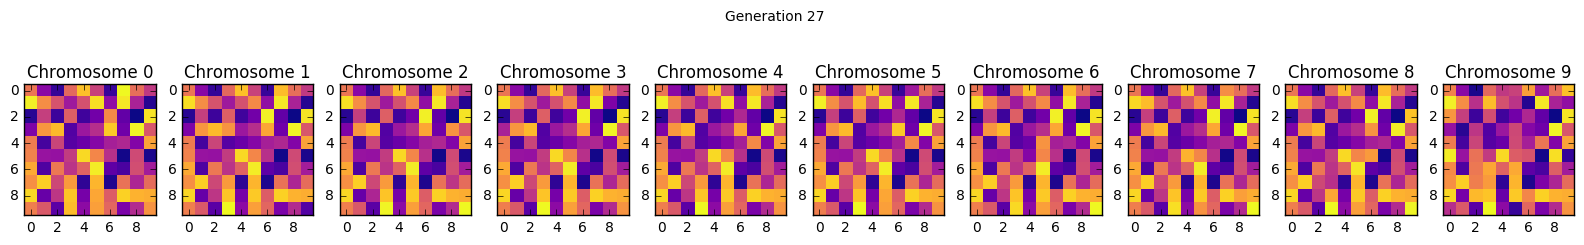

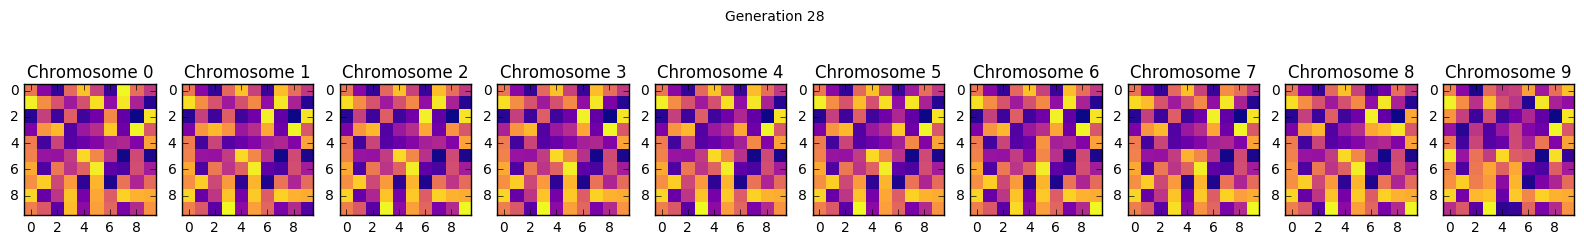

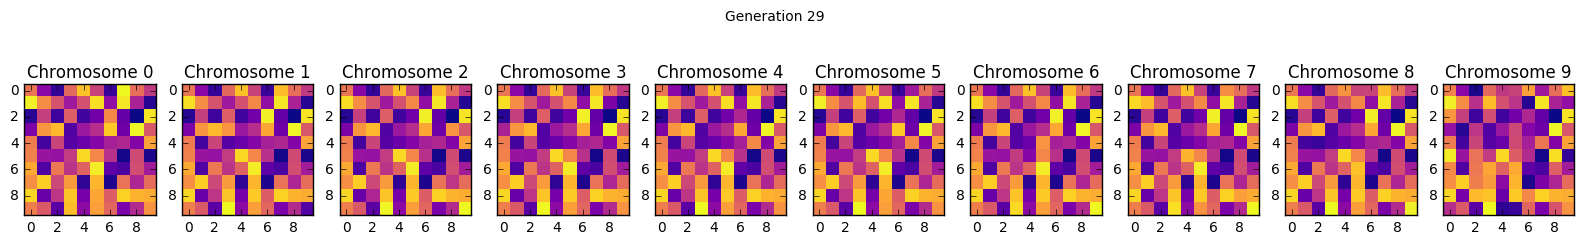

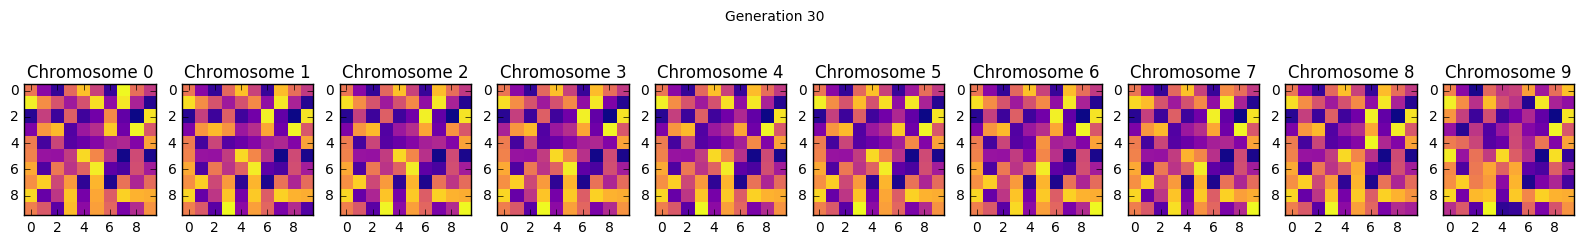

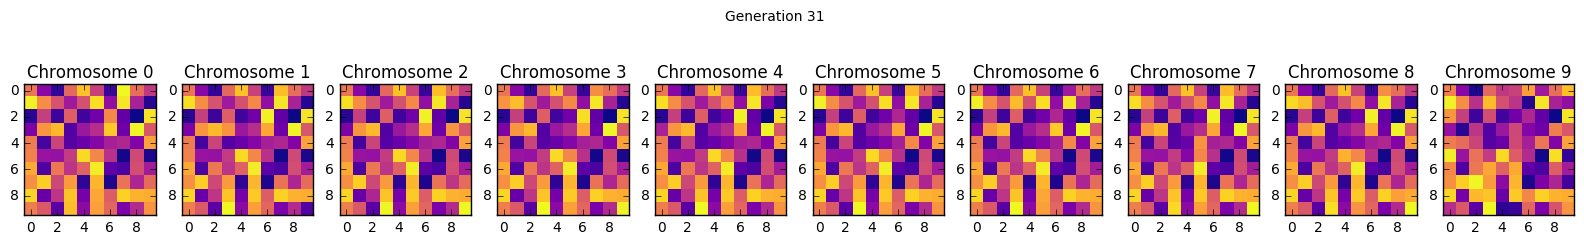

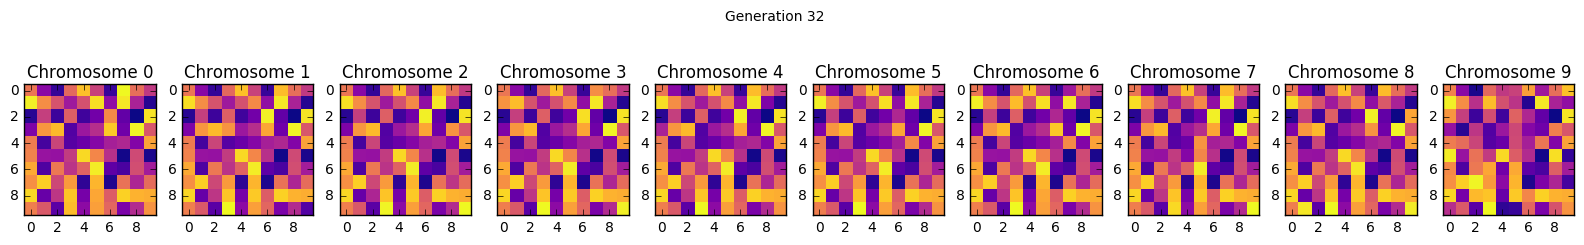

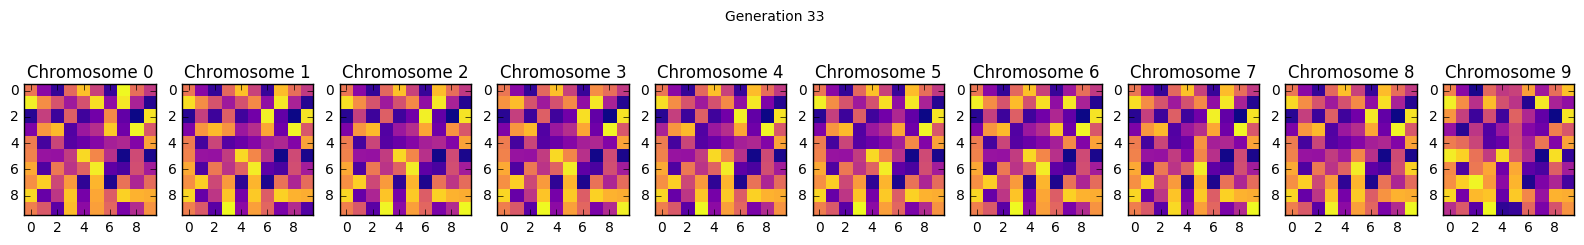

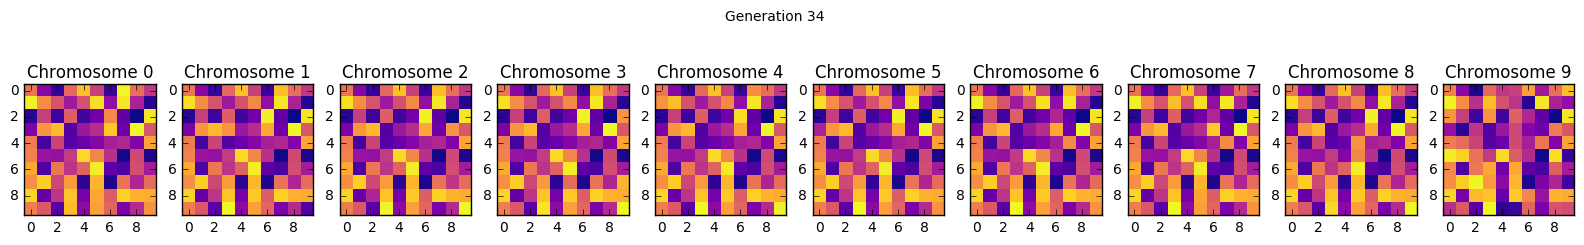

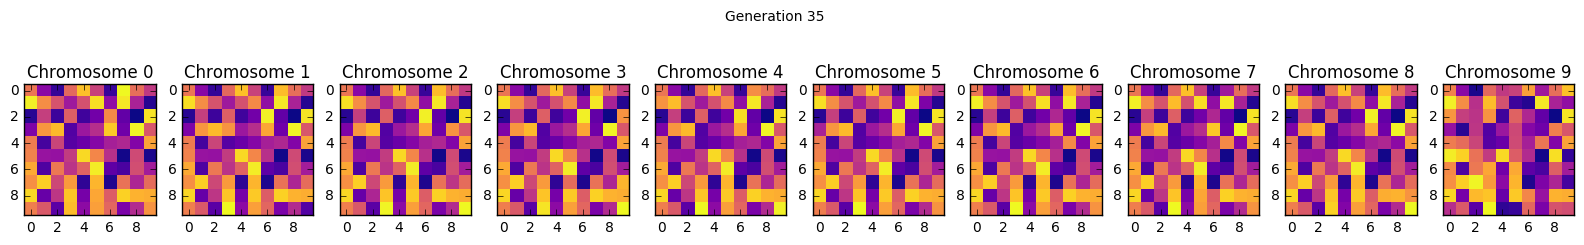

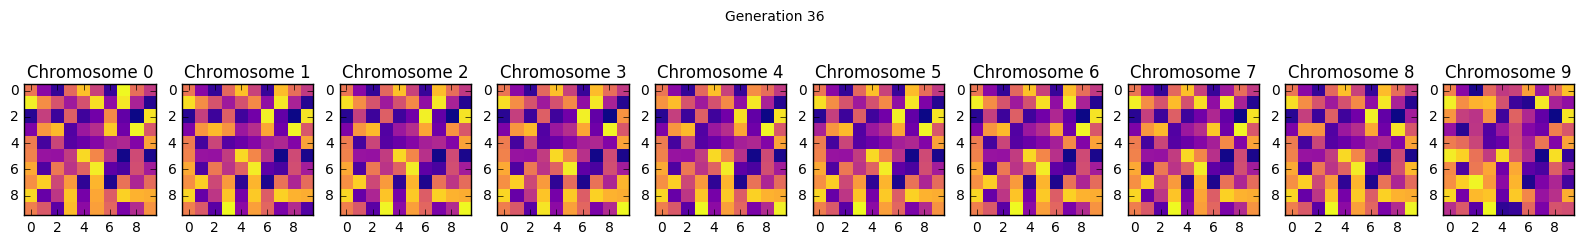

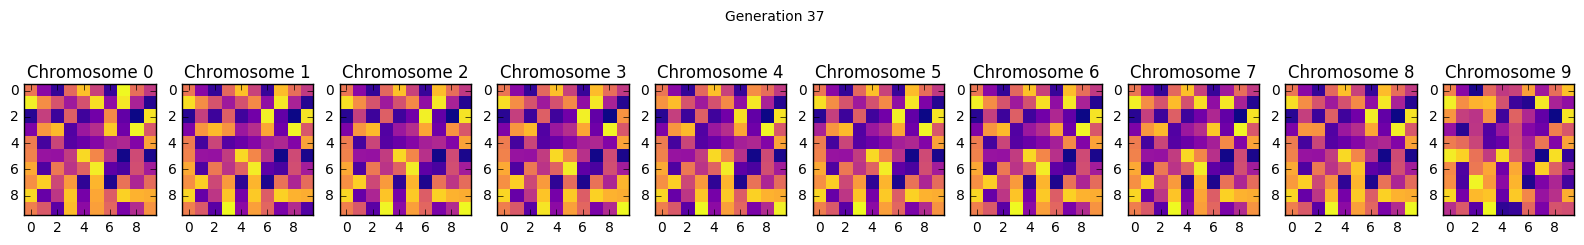

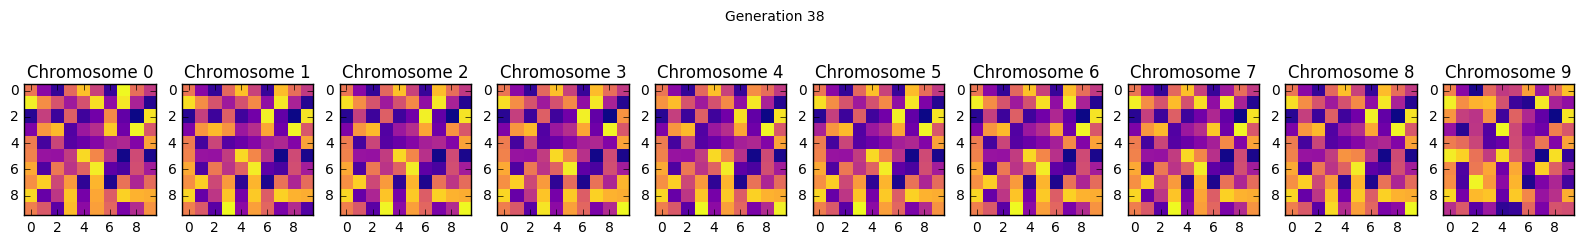

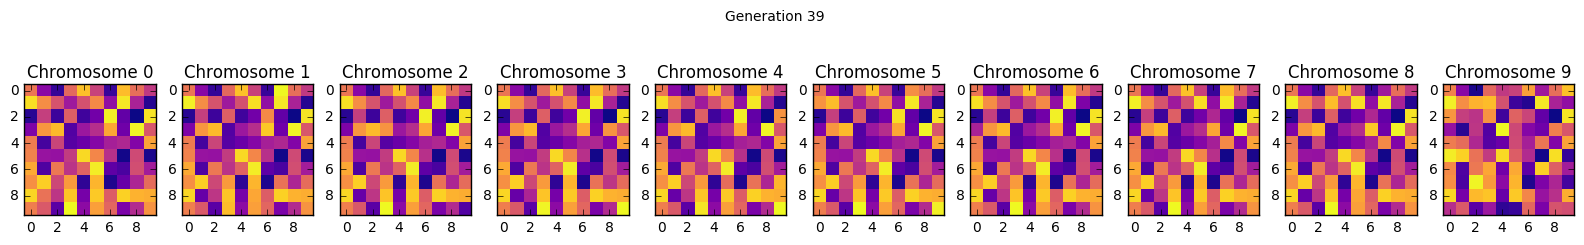

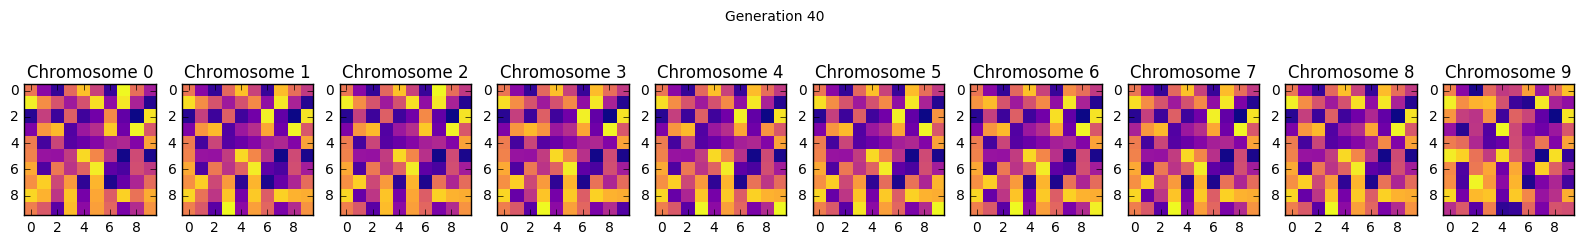

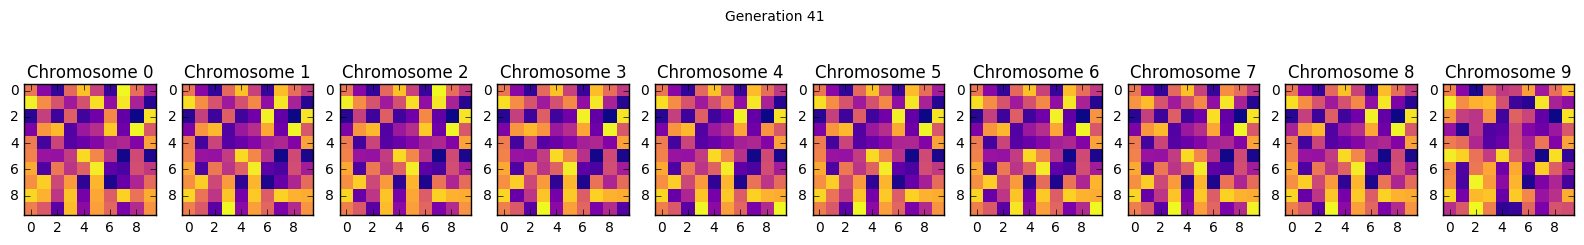

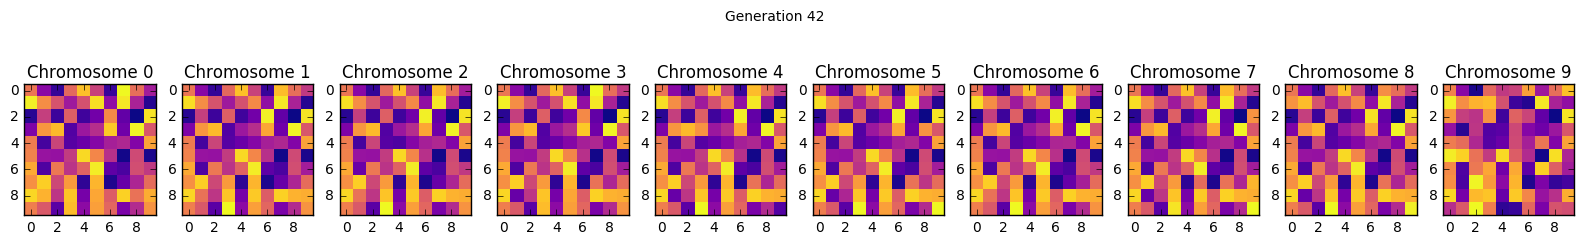

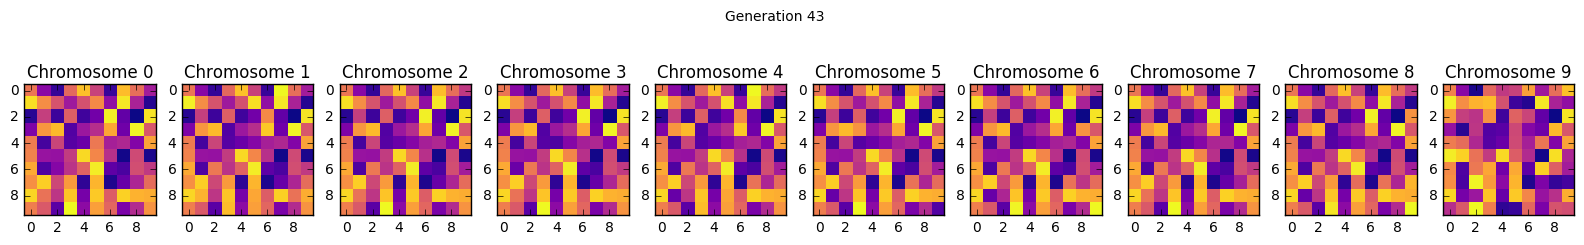

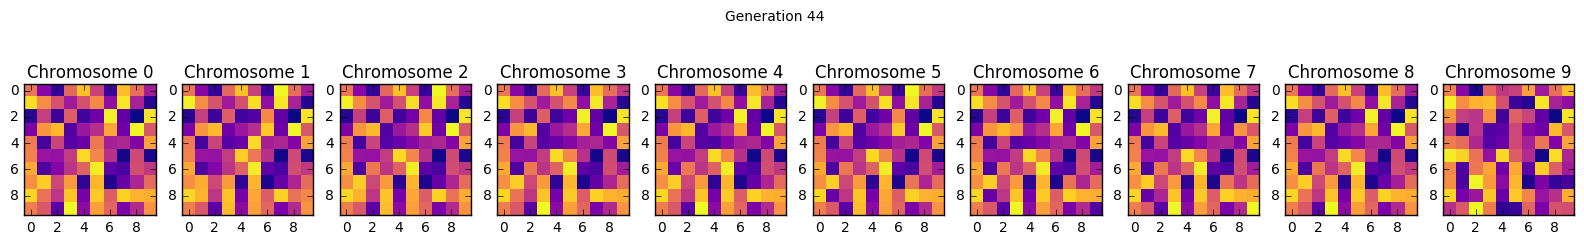

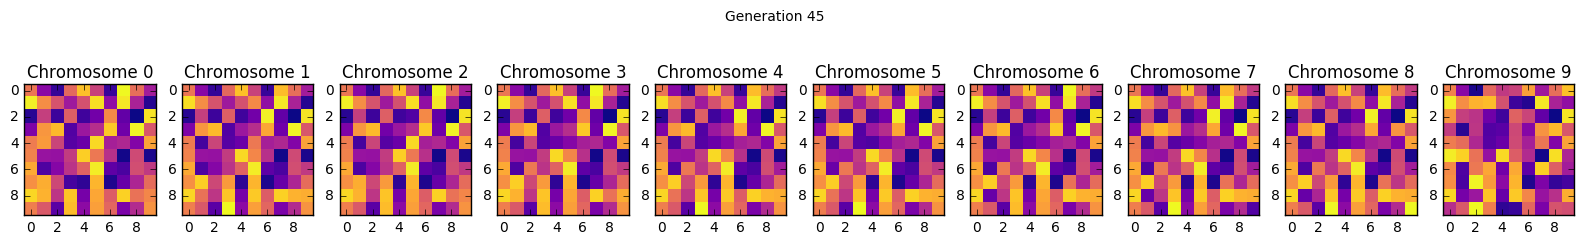

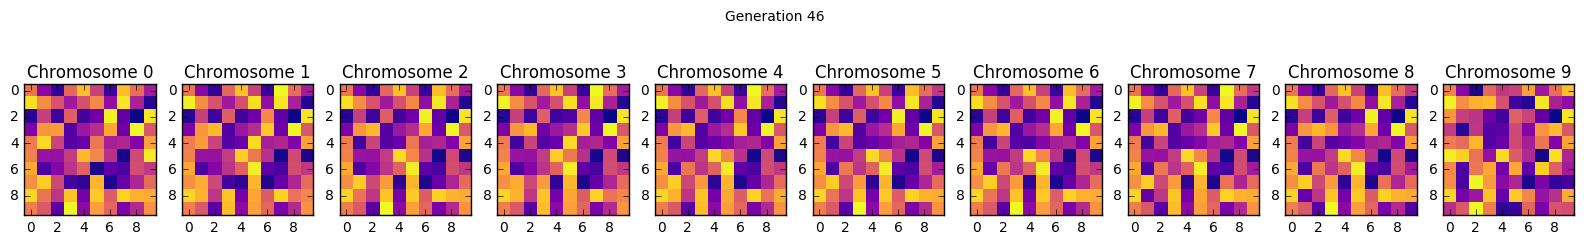

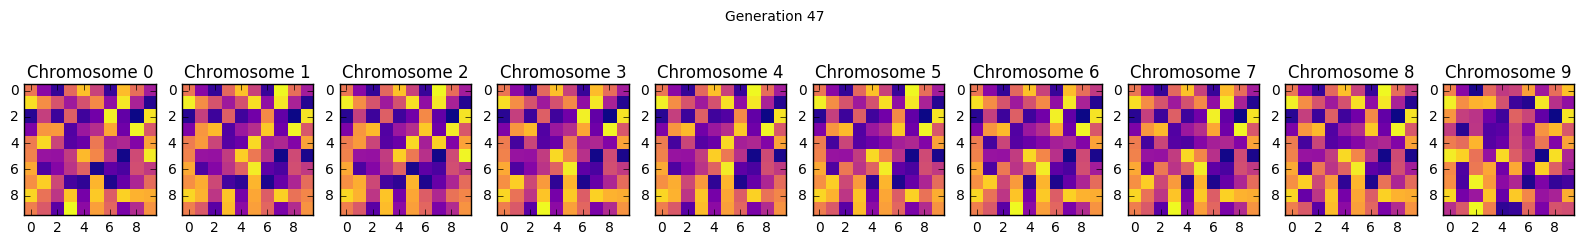

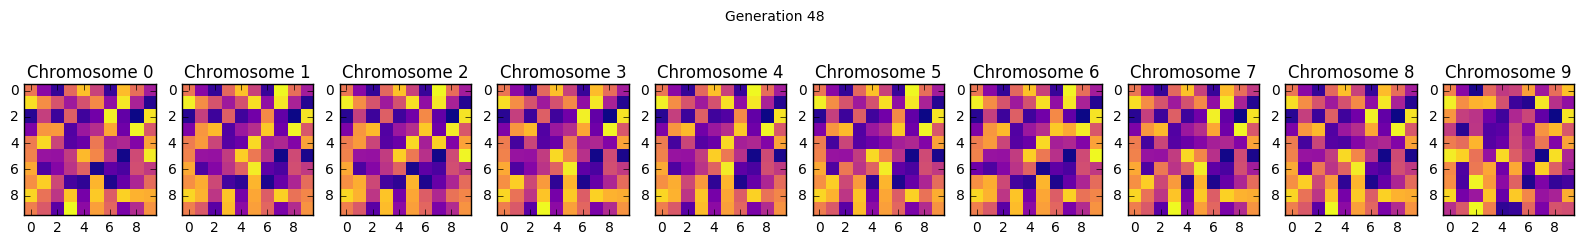

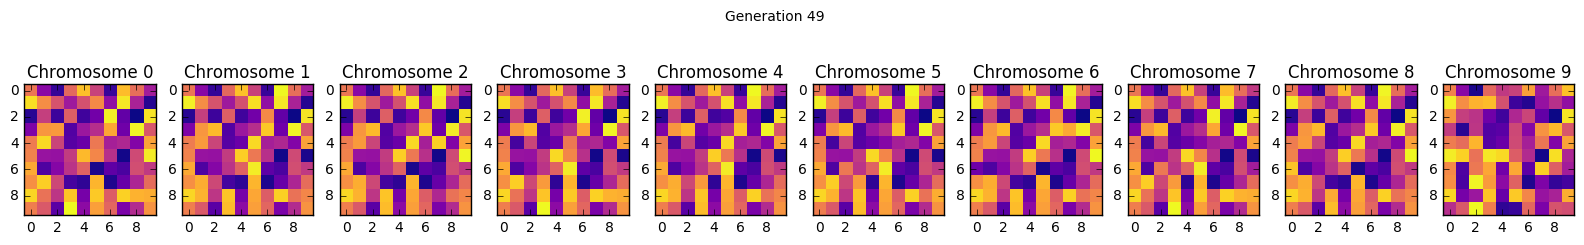

In [18]:
most_fit, fittest_chromosome = run_ga(generations)

到这里，遗传算法就告一段落了，我们最后看看这个model的表现吧

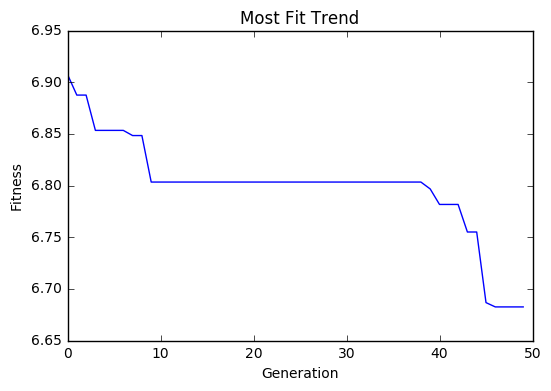

In [19]:
plt.plot(most_fit)
plt.title("Most Fit Trend")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

In [20]:
fittest_chromosome

array([[  66.,   29.,    8.,   62.,   87.,   49.,    9.,   86.,   64.,
          36.],
       [  94.,   73.,   55.,   35.,   54.,   72.,   31.,   96.,   38.,
           5.],
       [   6.,   48.,   10.,   59.,   11.,   23.,   98.,   19.,    1.,
          95.],
       [  26.,   76.,   77.,   15.,   34.,   42.,   80.,   22.,   99.,
          56.],
       [  68.,   93.,   50.,   16.,   21.,   67.,   37.,   40.,   27.,
          79.],
       [  70.,   33.,   32.,   47.,   85.,   71.,   43.,    2.,   52.,
          97.],
       [  81.,   14.,   28.,   44.,   60.,    3.,   18.,   13.,   53.,
          46.],
       [  74.,   90.,   51.,   12.,    7.,   84.,    4.,   20.,   39.,
          63.],
       [  92.,   65.,   45.,   88.,   24.,   89.,   58.,   91.,   83.,
          82.],
       [  69.,   57.,   17.,  100.,   30.,   78.,   61.,   25.,   41.,
          75.]])